## 1. Import Library
___

In [1]:
import gc 
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import *

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split

import tensorflow.keras.backend as K, gc


import warnings 
import albumentations as albu
warnings.filterwarnings('ignore')

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None

2024-08-06 10:08:42.671607: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 10:08:42.671722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 10:08:42.959307: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version:  2.15.0
Using 2 GPUs


In [2]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [4]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


## 2. Road and Read Data
___

In [5]:
df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
print(f'Shape of DataFrame: {df.shape}')
df.head()

Shape of DataFrame: (112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [6]:
%%time
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','images', '*.png'))}    
    
df['path'] = df['Image Index'].map(tmp)

CPU times: user 550 ms, sys: 79.6 ms, total: 630 ms
Wall time: 4.31 s


In [7]:
df = df[~df['Finding Labels'].str.contains('\|')]

**Loading Pneumonia**

- width: 1200
- height: 825

In [8]:
df_pneumonia = pd.DataFrame()
df_pneumonia['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/')
df_pneumonia['Finding Labels'] = 'Pneumonia'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','train','*','*.jpeg'))}        
df_pneumonia['path'] = df_pneumonia['Image Index'].map(tmp)
df_pneumonia['Patient ID'] = [f'pneumonia_{i}' for i in range(len(df_pneumonia))]

df = pd.concat([df, df_pneumonia])
df = df.reset_index(drop=True)

**Loading tuberculosis**

- width: 512
- height: 512

In [9]:
df_tuberculosis = pd.DataFrame()
df_tuberculosis['Image Index'] = os.listdir('/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis/')
df_tuberculosis['Finding Labels'] = 'Tuberculosis'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*','*.png'))}        
df_tuberculosis['path'] = df_tuberculosis['Image Index'].map(tmp)
df_tuberculosis['Patient ID'] = [f'tub_{i}' for i in range(len(df_tuberculosis))]


df = pd.concat([df, df_tuberculosis])
df = df.reset_index(drop=True)

**Load Covid-19**

- height: 825
- width: 1200

In [10]:
train_covid = pd.DataFrame()
train_covid['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/COVID19/')
test_covid = pd.DataFrame()
test_covid['Image Index'] = os.listdir('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/COVID19/')
df_covid = pd.concat([train_covid, test_covid])
df_covid['Finding Labels'] = 'Covid'

tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', '*','*','*','*.jpg'))}        
df_covid['path'] = df_covid['Image Index'].map(tmp)
df_covid['Patient ID'] = [f'covid_{i}' for i in range(len(df_covid))]


df = pd.concat([df, df_covid])
df = df.reset_index(drop=True)
df['Label'] = df['Finding Labels'].copy()
df = df[['Image Index','Finding Labels', 'path', 'Label', 'Patient ID']]
df['Patient ID'] = df['Patient ID'].astype('str')

In [11]:
df_1 = pd.concat([df[df['Label'] == 'Edema'].sample(500, random_state=42)])
df_2 = pd.concat([df[df['Label'] == 'No Finding'].sample(500, random_state=42)])
df_3 = pd.concat([df[df['Label'] == 'Pneumonia'].sample(500, random_state=42)])
df_4 = pd.concat([df[df['Label'] == 'Tuberculosis'].sample(500, random_state=42)])
df_5 = pd.concat([df[df['Label'] == 'Cardiomegaly'].sample(500, random_state=42)])
df_6 = pd.concat([df[df['Label'] == 'Emphysema'].sample(500, random_state=42)])
df_7 = pd.concat([df[df['Label'] == 'Covid'].sample(500, random_state=42)])
df_8 = pd.concat([df[df['Label'] == 'Effusion'].sample(500, random_state=42)])
df_9 = pd.concat([df[df['Label'] == 'Atelectasis'].sample(500, random_state=42)])


df = pd.concat([df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9])
df = df.reset_index(drop=True)

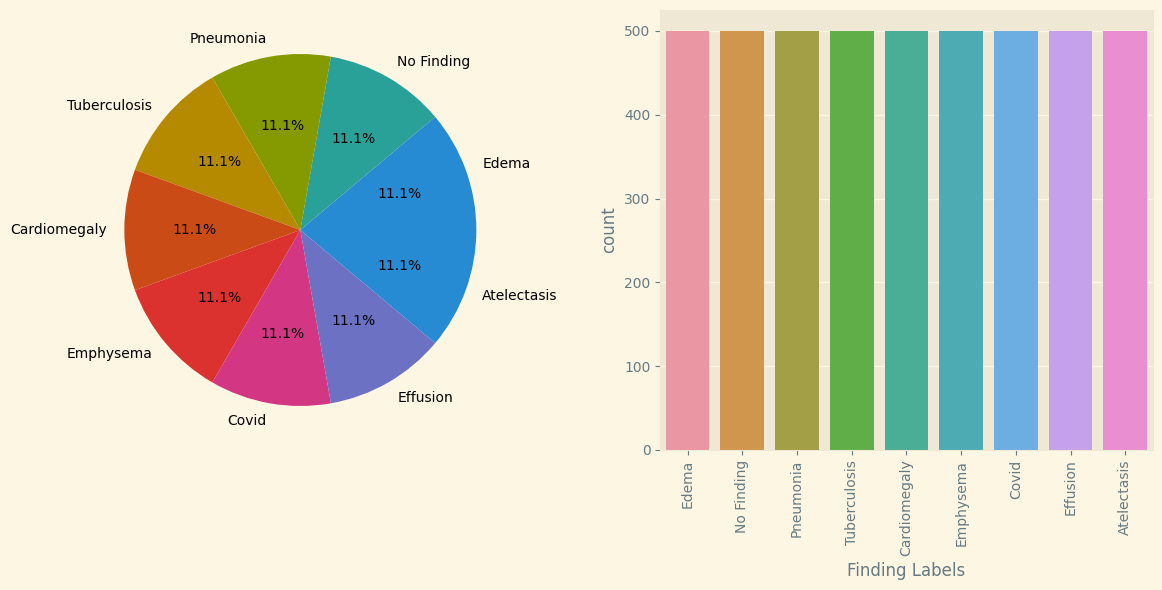

In [12]:
label_counts = df['Finding Labels'].value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**Train & Test Split**

In [13]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [14]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0,0.0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0,0.0).astype('float32')
TARGET = df_train.columns[-9:].tolist()

In [15]:
TARGET

['Edema',
 'No Finding',
 'Pneumonia',
 'Tuberculosis',
 'Cardiomegaly',
 'Emphysema',
 'Covid',
 'Effusion',
 'Atelectasis']

## 3. Build DataGenerator
___

In [16]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
        
    def __len__(self):
        
        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        return X,y
    
    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
        
    def __data_generation(self, indexes):
        
        X = np.zeros((len(indexes),256,256,3), dtype='float32') 
        y = np.zeros((len(indexes),len(TARGET)), dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((256,256), Image.Resampling.LANCZOS) # DownSampling
            img = np.array(img) # PIL Object -> np.array(uint8)
            img = self.clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
            
            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)
           
            
            X[j,:,:] = img
            y[j,] = row[TARGET]
            
        return X,y
    
    def __augment1(self, img_batch):
        
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),            
            
        ])
        
        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img
            
        return img_batch
    
    
    def __augment2(self, img_batch, mixup_prob=0.1):
        batch_size, height, width, channels = img_batch.shape

        idx = np.random.permutation(batch_size)
        lam = np.random.beta(2.0, 2.0) 
        
        for i in range(batch_size):
            if np.random.rand() <= mixup_prob:  
                j = idx[i]
            
                img_batch[i] = img_batch[i] * lam + img_batch[j] * (1-lam)
        
        return img_batch

## 4. Build EfficientNet-CBAM Model
___

**Two Attention Module**

1) CAM(Channel Attention Module)
2) SAM(Spatial Attention Module)

![](https://www.mdpi.com/forests/forests-13-00001/article_deploy/html/images/forests-13-00001-g004-550.jpg)

In [17]:
!pip install -q -U git+https://github.com/qubvel/efficientnet
    
import efficientnet.tfkeras as efn

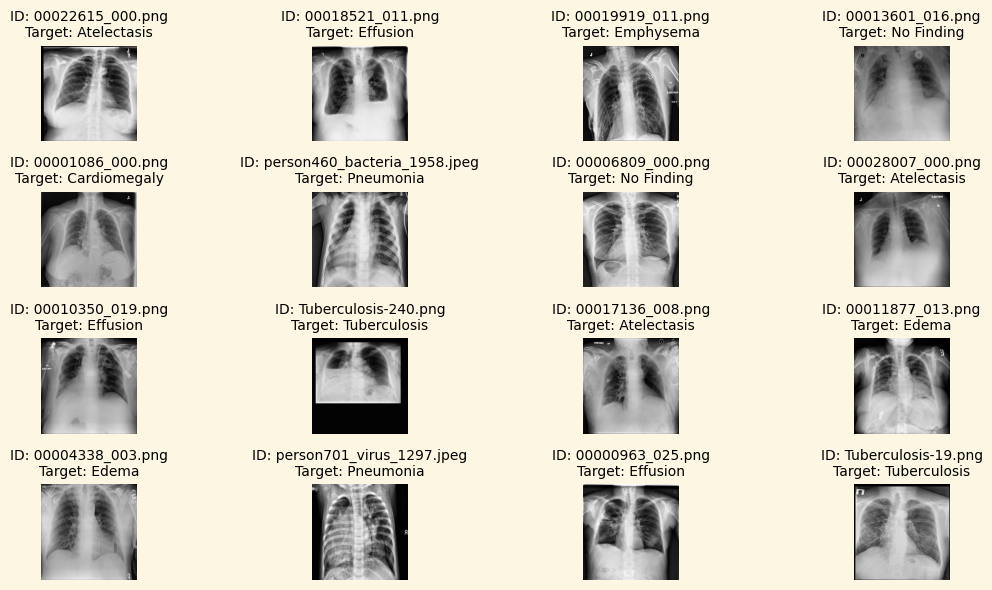

In [18]:
ROWS = 4; COLS = 4; BATCHES = 1

gen = DataGenerator(df_train, batch_size=16, shuffle=False, augment1=True, augment2=False, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

**Macro F1 Score**

In [19]:
def f1_score(y_true, y_pred):
    # Calculate the F1 score for each class
    f1_scores = []
    num_classes = K.int_shape(y_pred)[-1]  # (batch_size, output_dims = num_classes)
    
    # Get the true and predicted class indices
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1) # For Label Smoothing(in CCE)

    for i in range(num_classes):
        true_positives = K.sum(K.cast(tf.logical_and(K.equal(y_true, i), K.equal(y_pred, i)), dtype=tf.float32))
        possible_positives = K.sum(K.cast(K.equal(y_true, i), dtype=tf.float32))
        predicted_positives = K.sum(K.cast(K.equal(y_pred, i), dtype=tf.float32))

        recall = true_positives / (possible_positives + K.epsilon())
        precision = true_positives / (predicted_positives + K.epsilon())
        
        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        f1_scores.append(f1_score)
    
    # Calculate the macro-average F1 score
    macro_f1_score = K.mean(tf.stack(f1_scores))
    return macro_f1_score

**Build CBAM Layer**

In [20]:
class CAM(layers.Layer):
    def __init__(self, ratio=8):
        super().__init__()
        self.ratio = ratio
        self.gap = layers.GlobalAveragePooling2D()
        self.gmp = layers.GlobalMaxPooling2D()
        
    def build(self, input_shape):
        self.conv1 = layers.Conv2D(input_shape[-1]//self.ratio,
                                   kernel_size=1,
                                   strides=1, padding='same',
                                   activation='relu')
        self.conv2 = layers.Conv2D(input_shape[-1],
                                   kernel_size=1,
                                   strides=1, padding='same',
                                   activation='relu')
    
    def call(self, inputs):
        gap = self.gap(inputs)
        gmp = self.gmp(inputs)
        gap = layers.Reshape((1,1,gap.shape[1]))(gap)
        gmp = layers.Reshape((1,1,gmp.shape[1]))(gmp)
        gap_out = self.conv2(self.conv1(gap))
        gmp_out = self.conv2(self.conv1(gmp))
        
        return tf.math.sigmoid(gap_out+gmp_out)
    
class SAM(layers.Layer):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.conv1 = layers.Conv2D(64,kernel_size=kernel_size,
                                   use_bias=False, kernel_initializer='he_normal',
                                   strides=1, padding='same', activation='relu')
        self.conv2 = layers.Conv2D(32,kernel_size=kernel_size,
                                   use_bias=False, kernel_initializer='he_normal',
                                   strides=1, padding='same', activation='relu')
        self.conv3 = layers.Conv2D(16,kernel_size=kernel_size,
                                   use_bias=False, kernel_initializer='he_normal',
                                   strides=1, padding='same', activation='relu')
        self.conv4 = layers.Conv2D(1,kernel_size=kernel_size,
                                   use_bias=False, kernel_initializer='he_normal',
                                   strides=1, padding='same', activation='sigmoid')
        
        
    def call(self,inputs):
        
        avg_out = tf.reduce_mean(inputs, axis=3)
        max_out = tf.reduce_max(inputs, axis=3)
        x = tf.stack([avg_out, max_out], axis=3)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.conv4(x)

In [21]:
class AttentionWeightedAverage2D(layers.Layer):
    def __init__(self, **kwargs):
        self.init = tf.keras.initializers.get('uniform')
        super(AttentionWeightedAverage2D, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [layers.InputSpec(ndim=4)]
        assert len(input_shape) == 4
        self.W = self.add_weight(shape=(input_shape[3], 1),
                                 name='{}_W'.format(self.name),
                                 initializer=self.init)
        self._trainable_weights = [self.W]
        super(AttentionWeightedAverage2D, self).build(input_shape)

    def call(self, x):
        # computes a probability distribution over the timesteps
        # uses 'max trick' for numerical stability
        # reshape is done to avoid issue with Tensorflow
        # and 2-dimensional weights
        logits  = K.dot(x, self.W)
        x_shape = K.shape(x)
        logits  = K.reshape(logits, (x_shape[0], x_shape[1], x_shape[2]))
        ai      = K.exp(logits - K.max(logits, axis=[1,2], keepdims=True))
        
        att_weights    = ai / (K.sum(ai, axis=[1,2], keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(att_weights)
        result         = K.sum(weighted_input, axis=[1,2])
        return result

In [22]:
def build_model():
    inp = layers.Input(shape=(256,256,3))
    base_model = efn.EfficientNetB0(include_top=False, weights='noisy-student', input_shape=(256,256,3))
    
    # Freezing Layers
    for layer in base_model.layers[:len(base_model.layers)//10]:
        layer.trainable = False
   
    # Output
    x0 = base_model(inp) # 8X8X512
    x = CAM()(x0) # 1x1x512
    x = layers.Multiply()([x0,x]) # 8X8X512
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(len(TARGET), activation='softmax', dtype='float32')(x)
    
    
    # Compile
    model = Model(inputs=inp, outputs=x)
    loss = losses.CategoricalCrossentropy(label_smoothing=0.1)
    opt = optimizers.Adam(learning_rate=1e-3)
    
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy',f1_score])
    
    return model

16696600/16696600 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


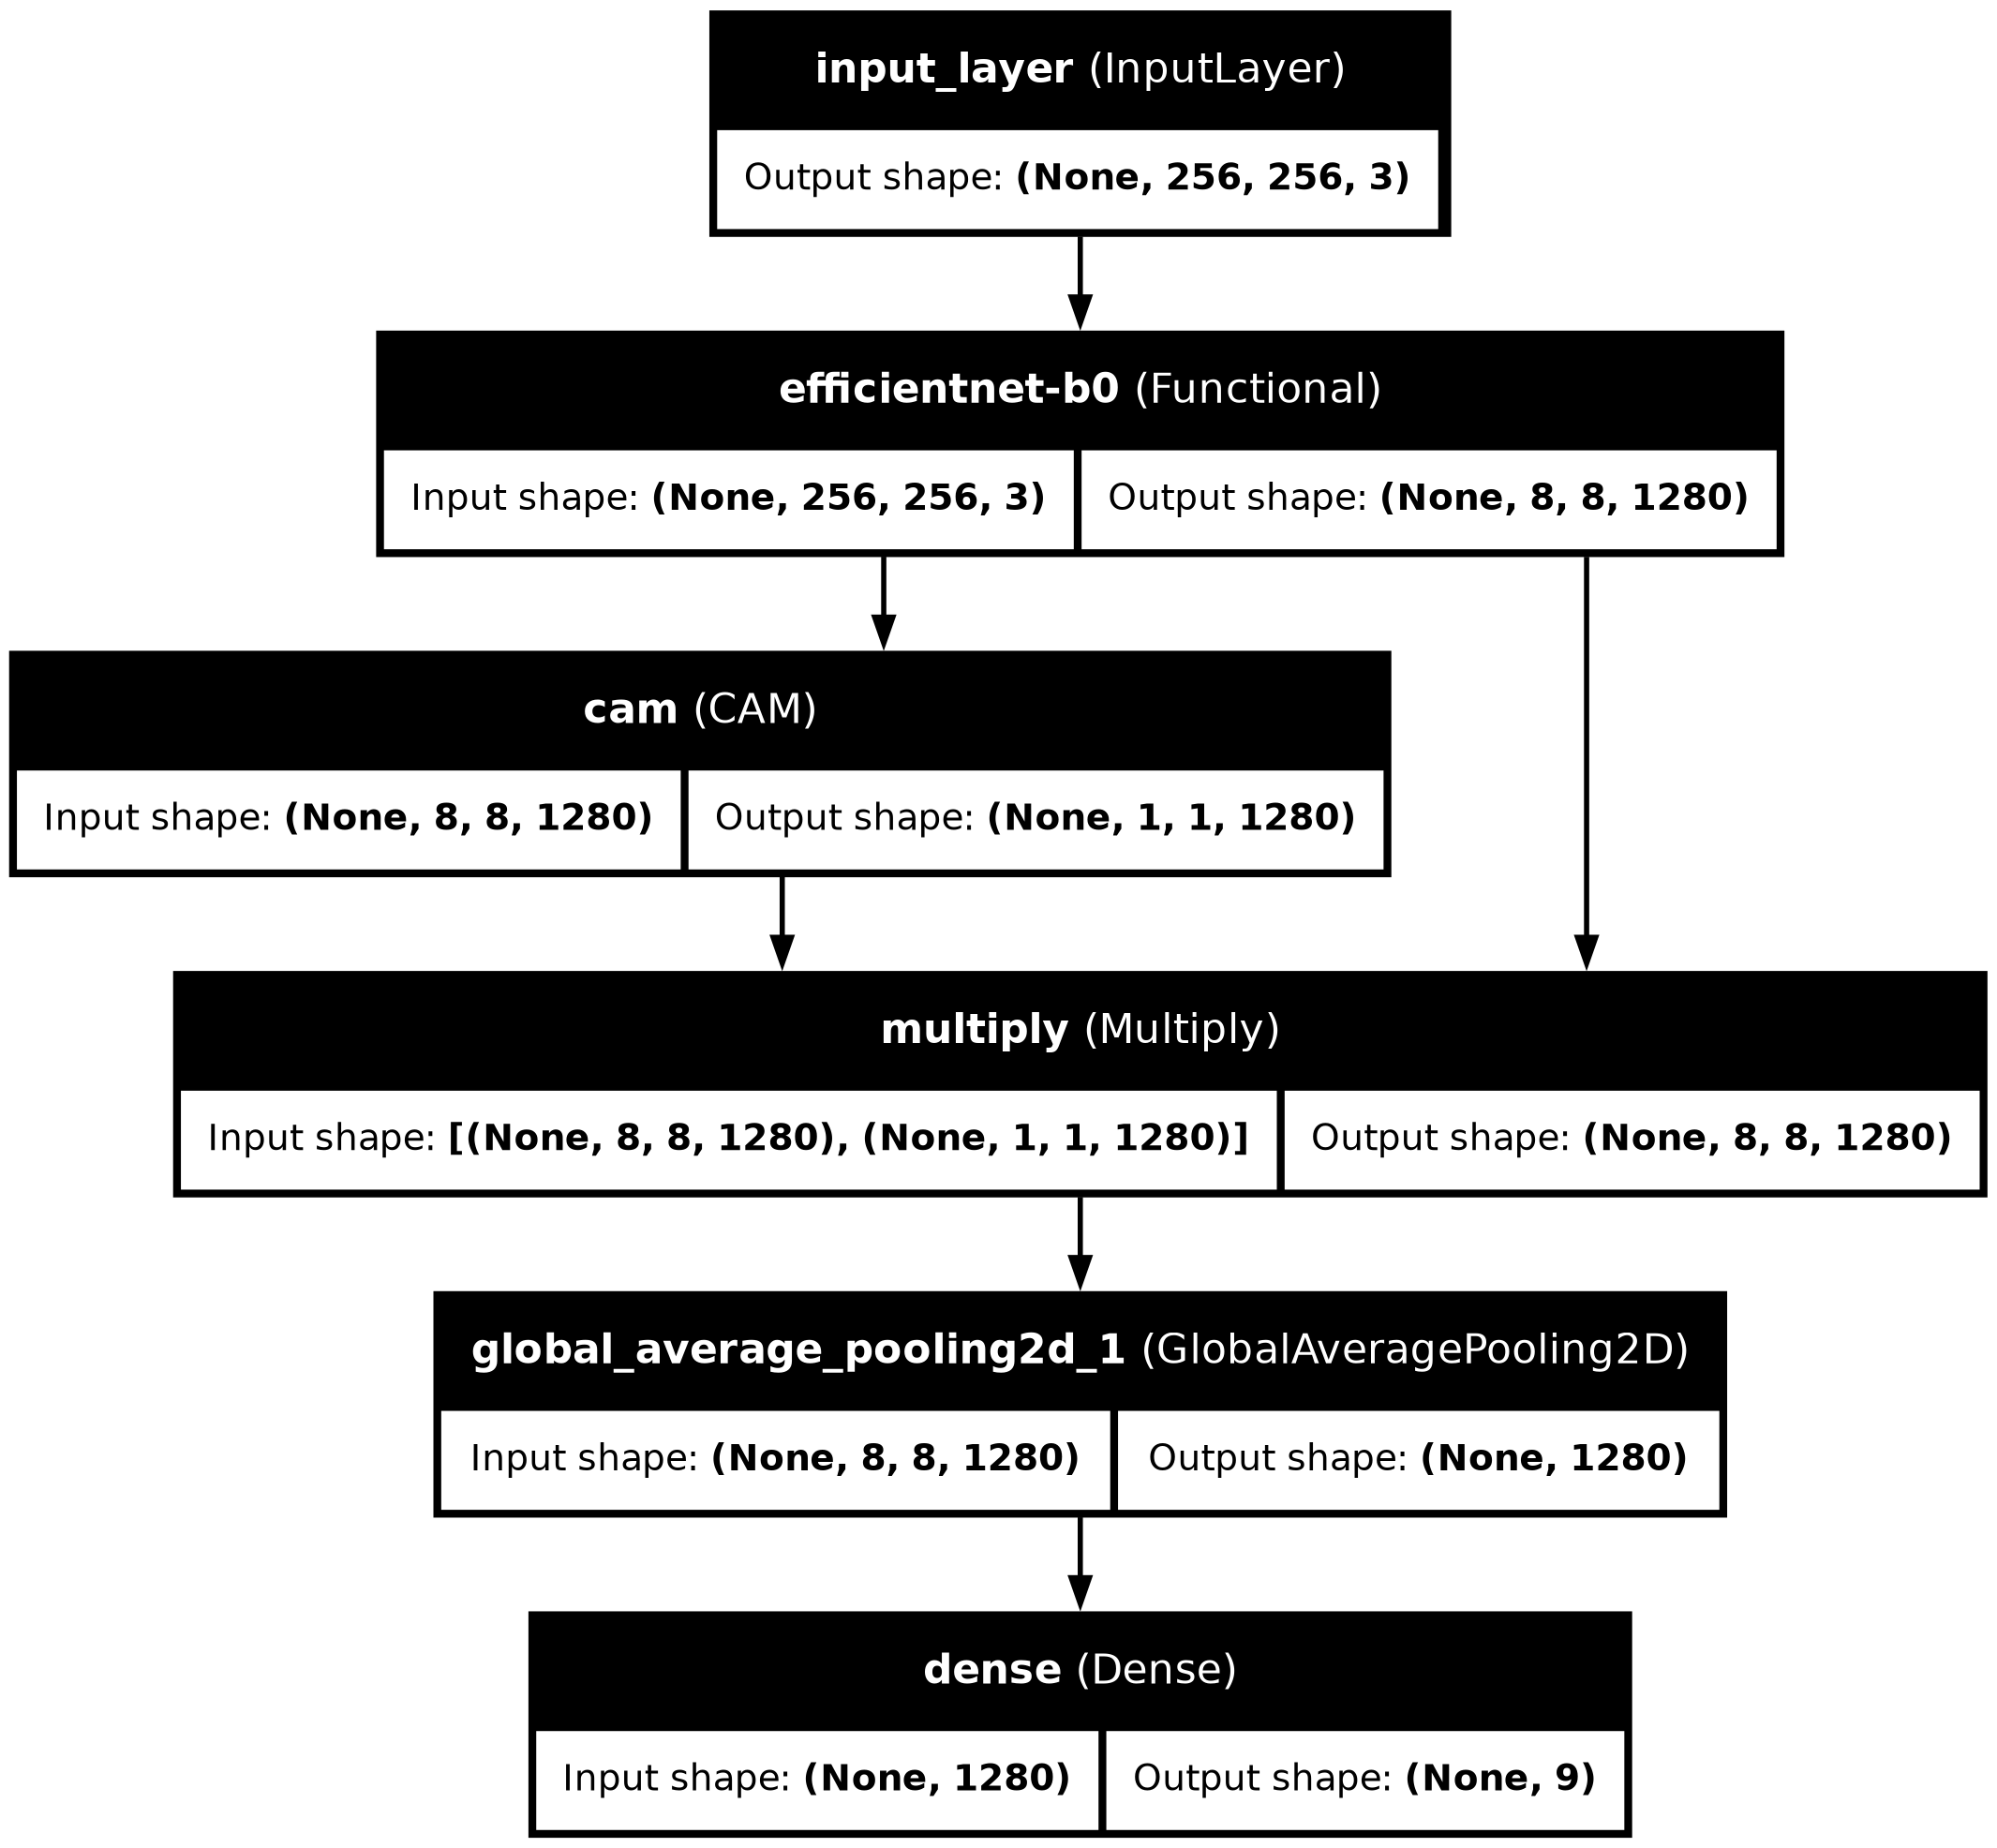

In [23]:
from tensorflow.keras.utils import plot_model
model = build_model()
#model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping 

EPOCHS = 10

es = EarlyStopping(monitor='val_f1_score', mode='max', patience=5)
lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

#########################
### Fold 1
### train size 2880, valid size 720
#########################
Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 273s 818ms/step - accuracy: 0.3847 - f1_score: 0.2233 - loss: 1.7927 - val_accuracy: 0.4583 - val_f1_score: 0.3039 - val_loss: 1.7683 - learning_rate: 0.0010
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 100s 536ms/step - accuracy: 0.5525 - f1_score: 0.3319 - loss: 1.4644 - val_accuracy: 0.5889 - val_f1_score: 0.4404 - val_loss: 1.5513 - learning_rate: 0.0010
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.5945 - f1_score: 0.3717 - loss: 1.3857
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
180/180 ━━━━━━━━━━━━━━━━━━━━ 100s 540ms/step - accuracy: 0.5945 - f1_score: 0.3717 - loss: 1.3857 - val_accuracy: 0.5750 - val_f1_score: 0.4221 - val_loss: 1.6566 - learning_rate: 0.0010
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 100s 538ms/step - accuracy: 0.6523 - f1_score: 0.4044 - loss: 1.2365 - val_accuracy: 0.7000 - 

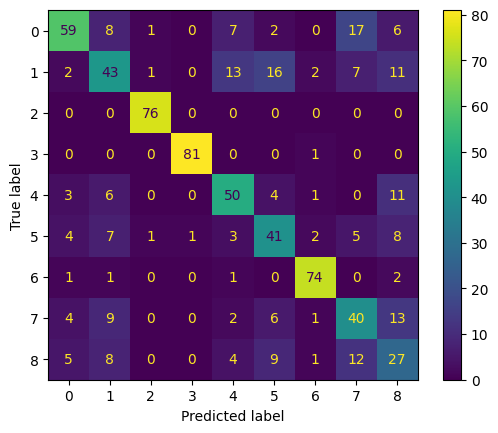

In [26]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=False, batch_size=16, preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=32, preprocess=efn.preprocess_input)
    
    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'EffNet_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid F1'].append(history.history['val_f1_score'])
        all_history['Train F1'].append(history.history['f1_score'])
        all_history['Valid Accuracy'].append(history.history['val_accuracy'])
        all_history['Train Accuracy'].append(history.history['accuracy'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_f{i}.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    
    plt.style.use('default')
    cm = confusion_matrix(np.argmax(oof, axis=1), np.argmax(df_train[df_train['Fold'] == i][TARGET].values, axis=1), labels=[x for x in range(len(TARGET))])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[x for x in range(len(TARGET))])  
    disp.plot()
    plt.show()
    
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

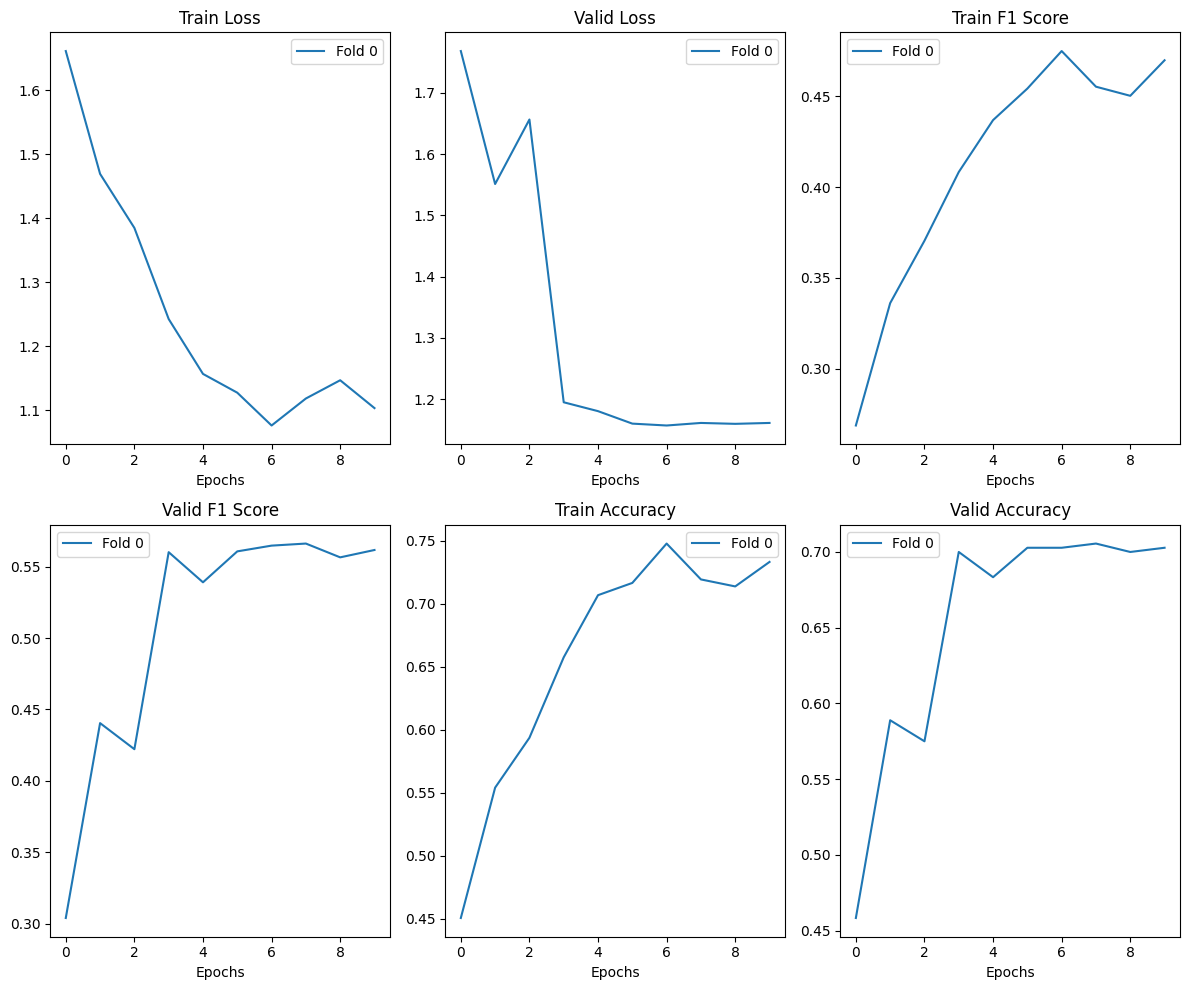

In [27]:
if LOAD_MODELS_FROM is None:
    plt.figure(figsize=(12,10))
    plt.subplot(2,3,1)
    plt.title('Train Loss')
    for fold, i in enumerate(all_history['Train Loss']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,2)
    plt.title('Valid Loss')
    for fold, i in enumerate(all_history['Valid Loss']):
        plt.plot(i,label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,3)
    plt.title('Train F1 Score')
    for fold, i in enumerate(all_history['Train F1']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(2,3,4)
    plt.title('Valid F1 Score')
    for fold, i in enumerate(all_history['Valid F1']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,5)
    plt.title('Train Accuracy')
    for fold, i in enumerate(all_history['Train Accuracy']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,3,6)
    plt.title('Valid Accuracy')
    for fold, i in enumerate(all_history['Valid Accuracy']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()


    
    plt.tight_layout()
    plt.show()

In [28]:
from sklearn.metrics import accuracy_score, f1_score

# Accuracy
accuracy = accuracy_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1))
print('Accuracy for Train Set =', accuracy)

# F1 Score
f1 = f1_score(np.argmax(all_true, axis=1), np.argmax(all_oof, axis=1) , average='macro')
print('F1 Score for Train Set =', f1)

Accuracy for Train Set = 0.6819444444444445
F1 Score for Train Set = 0.6795722468959169


## Inference

Fold 1
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2:09 9s/step

I0000 00:00:1722940210.540281      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step
Accuracy for Test Set = 0.66
F1 Score for Test Set = 0.6646115763566115


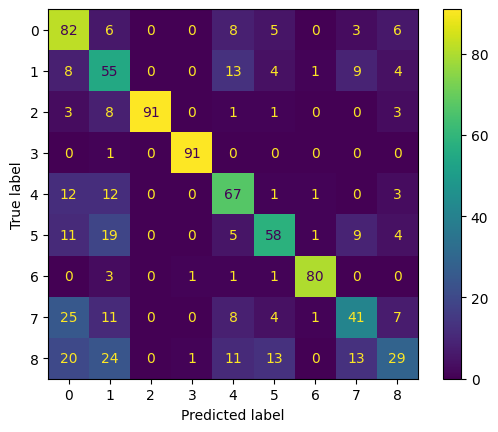

In [29]:
preds = []

## No TTA
test_gen = DataGenerator(df_test, shuffle=False, batch_size=64, preprocess=efn.preprocess_input)

for i in range(1):
    K.clear_session()
    print(f'Fold {i+1}') 
    model = build_model()
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}EffNet_f{i}.weights.h5')
    else: 
        model.load_weights(f'EffNet_f{i}.weights.h5')
    
    pred = model.predict(test_gen, verbose=1) 
    
preds.append(pred)
pred_res = np.mean(preds,axis=0)
    
# Accuracy 
accuracy = accuracy_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1))
print('Accuracy for Test Set =', accuracy)

# F1 Score 
f1 = f1_score(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), average='macro') 
print('F1 Score for Test Set =', f1)

cm = confusion_matrix(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), labels=[x for x in range(len(TARGET))])
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[x for x in range(len(TARGET))])
display.plot()
plt.show()

In [30]:
TARGET

['Edema',
 'No Finding',
 'Pneumonia',
 'Tuberculosis',
 'Cardiomegaly',
 'Emphysema',
 'Covid',
 'Effusion',
 'Atelectasis']